# Implicit hate speech detection
# Roberta model

In [33]:
# !pip install evaluate
# !pip install seqeval
# !pip install ipywidgets
# !pip install transformers datasets seqeval evaluate
# !pip install pyfunctional
# !pip install torch torchvision
# !pip install spacy
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy validate
# !pip install "numpy<2"
# !pip install "thinc<8.3.6"
# !pip install transformers
# !pip install --upgrade transformers
# !pip install 'accelerate>=0.26.0'
# !pip install nltk
# !pip install pandas
# !pip install transformers torch
# !pip install 'accelerate>=0.26.0'
# !pip install transformers[torch]
# !pip install --upgrade 'accelerate>=0.26.0'
# !pip install "accelerate>=0.21.0" -U
# !pip install --force-reinstall "accelerate>=0.21.0"
# !pip install --upgrade pip setuptools wheel
# !curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
# !pip install "transformers<4.30.0"
# !pip install --force-reinstall "accelerate>=0.21.0"
# !pip install numpy==1.24.4 fsspec==2024.6.1 packaging==24.0
# !pip install accelerate -U
# !pip install "numpy<2"


# import transformers
# import accelerate
# print(f"Transformers version: {transformers.__version__}")
# print(f"Accelerate version: {accelerate.__version__}")

# !pip uninstall transformers -y
# !pip uninstall tokenizers -y
# !pip uninstall huggingface_hub -y
# !pip uninstall safetensors -y
# !pip install "fsspec<=2024.12.0"
# !pip install --no-cache-dir transformers==4.51.3
# import transformers
# print(transformers.__version__)
# from transformers import TrainingArguments, Trainer


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tree import Tree
from nltk.stem.porter import PorterStemmer
import re
from collections import Counter
import string
import pandas as pd
# import spacy
# from spacy.tokens import Doc
# from spacy import displacy
# import benepar
from itertools import chain
import sklearn
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
import pickle
import networkx as nx
import os, logging
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import re
# from datasets import load_dataset
from evaluate import load
from datasets import Dataset
import os
import csv

import pkg_resources
import subprocess
import sys

from numpy import log, mean
from pandas import Series, DataFrame

from typing import List, Tuple, Union
import glob

# from functional import seq
# from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from IPython.display import clear_output

from typing import Dict, List, Tuple, Union
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split

import torch
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification


In [2]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

text = "Hello, I'm a sentence that needs encoding."
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
model_checkpoint = "roberta-base"
task = "hate_detection"
batch_size = 16

# Roberta model training

In [6]:
trainset = "train_data.tsv"
devset = "dev_data.tsv"
testset = "test_data.tsv"

In [22]:
trainset_read = pd.read_csv(trainset, delimiter='\t')
print(trainset_read[:10])

                                                post          class
0  they are not dreamers, if they are illegal the...  implicit_hate
1   i get it . you feel bad for being white . you...       not_hate
2  saudi arabia is a disgusting, inhuman regime. ...  explicit_hate
3  2 hollywood jews want us to feel bad for not i...  explicit_hate
4  technically  the kkk commits no crimes . they ...       not_hate
5  poland uncovers thousands more staff at auschw...       not_hate
6                     its about erasing white people  implicit_hate
7  we who are pro-white want to preserve the whit...  implicit_hate
8  the yankees are so disenchanted with their wom...  implicit_hate
9                rape of europe  5sept2015 #altright       not_hate


In [23]:
devset_read = pd.read_csv(devset, delimiter='\t')
print(devset_read[:10])

                                                post          class
0  white community was a safe white community til...  explicit_hate
1  a fetus is a baby and needs to be treated w / ...       not_hate
2  that's not what he was saying . women voting o...  implicit_hate
3  thats why dhs should put chutes on illegals, l...  implicit_hate
4  : abortion has a market problem : #hb2 #protec...       not_hate
5    " police continue to stand down  people will...       not_hate
6  you have a good work ethic  and i'm sure a few...       not_hate
7                                        hello white       not_hate
8   rt but the  " third great awakening " " is ab...       not_hate
9  not wanting your people and culture erased is ...       not_hate


In [24]:
testset_read = pd.read_csv(testset, delimiter='\t')
print(testset_read[:10])

                                                post          class
0  more i learn  more i realize how similar jews ...  explicit_hate
1            they move into the third mixed nation .  implicit_hate
2  npr says southern baptists are raising the whi...       not_hate
3  wal mart queen hillary pontificates that modi ...       not_hate
4  trumps so mentally unstable calling himself wh...       not_hate
5  need a massive deportation program ... around ...  implicit_hate
6  democrats in white hoods have hung white repub...  implicit_hate
7  trump needs his hud examined : not a fan of fa...  explicit_hate
8  very unlikely for most unless its a massive pu...       not_hate
9  not generally . in some states  1/2 of black p...  implicit_hate


## Loading the dataset

In [25]:
with open(trainset, "r") as file:
    for i, line in enumerate(file):
        if i < 5:  
            print(line.strip())

post	class
"they are not dreamers, if they are illegal they aren't immigrant they are """"intruder invaders""""."	implicit_hate
" i get it . you feel bad for being white . you assume  "" white privilege "" "" and "" "" the patriarchy "" "" must be torn down . you want to help . not me . """	not_hate
saudi arabia is a disgusting, inhuman regime. truly evil. lower than vermin. still, business is business. kerching!	explicit_hate
2 hollywood jews want us to feel bad for not importing jihadists whose doctrine has more jew hate than mein kampf	explicit_hate


In [26]:
data = []
with open(trainset, "r") as file:
    for line in file:
        row = line.strip().split('\t')
        if len(row) >= 2:  
            data.append([row[0], row[1]]) 

df_train = pd.DataFrame(data, columns=['post', 'class'])

In [27]:
print("Train DataFrame columns:", df_train.columns.tolist())

Train DataFrame columns: ['post', 'class']


In [28]:
type(df_train['post'].iloc[0:10])

pandas.core.series.Series

In [29]:
data = []
with open(devset, "r") as file:
    for line in file:
        row = line.strip().split('\t')
        if len(row) >= 2:  
            data.append([row[0], row[1]]) 

df_dev = pd.DataFrame(data, columns=['post', 'class'])

In [30]:
print("Train DataFrame columns:", df_dev.columns.tolist())

Train DataFrame columns: ['post', 'class']


In [31]:
data = []
with open(testset, "r") as file:
    for line in file:
        row = line.strip().split('\t')
        if len(row) >= 2:  
            data.append([row[0], row[1]])  

df_test = pd.DataFrame(data, columns=['post', 'class'])


In [32]:
print("Train DataFrame columns:", df_test.columns.tolist())

Train DataFrame columns: ['post', 'class']


In [33]:
df_train['class'].value_counts()

class
not_hate         7919
implicit_hate    4296
explicit_hate     672
class               1
                    1
Name: count, dtype: int64

In [34]:
df_dev['class'].value_counts()

class
not_hate         2677
implicit_hate    1397
explicit_hate     222
class               1
Name: count, dtype: int64

In [35]:
df_test['class'].value_counts()

class
not_hate         2695
implicit_hate    1406
explicit_hate     195
class               1
Name: count, dtype: int64

## Data Preprocessing

In our dataset, the labels are organized like this:

not_hate
implicit_hate
explicit_hate


In [36]:
model.resize_token_embeddings(len(tokenizer))

Embedding(50265, 768, padding_idx=1)

In [7]:
from datasets import load_dataset

dataset_train = load_dataset('csv', data_files={'train': 'train_data.tsv'}, delimiter='\t')
dataset_dev = load_dataset('csv', data_files={'dev': 'dev_data.tsv'}, delimiter='\t')
dataset_test = load_dataset('csv', data_files={'test': 'test_data.tsv'}, delimiter='\t')

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["post"], truncation=True, padding=True, max_length=512)

    # Mapping the 'class' labels to numerical labels (0 = not_hate, 1 = implicit_hate, 2 = explicit_hate)
    label_mapping = {"not_hate": 0, "implicit_hate": 1, "explicit_hate": 2}
    labels = [label_mapping[label] for label in examples["class"]]

    tokenized_inputs["labels"] = labels
    return tokenized_inputs



In [8]:
tokenized_datasets_train = dataset_train['train'].map(tokenize_and_align_labels, batched=True)

print(tokenized_datasets_train[10])

{'post': 'be brave and admit you a / zionist racist full of hate islam historicallywhat about your money collect', 'class': 'explicit_hate', 'input_ids': [0, 1610, 10025, 8, 8109, 47, 10, 1589, 992, 1499, 661, 7159, 455, 9, 4157, 16, 5112, 9644, 12196, 59, 110, 418, 5555, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 2}


In [9]:
tokenized_datasets_dev = dataset_dev['dev'].map(tokenize_and_align_labels, batched=True)

print(tokenized_datasets_dev[10])

{'post': 'interfered in their elect and inserted yeltsin  that the real numbers showed that communist party won and victory shld had gone 2 zyuganov', 'class': 'not_hate', 'input_ids': [0, 8007, 506, 3215, 11, 49, 10371, 8, 24557, 1423, 523, 1872, 179, 1437, 14, 5, 588, 1530, 969, 14, 19884, 537, 351, 8, 1124, 1481, 4779, 56, 1613, 132, 992, 219, 3252, 260, 1417, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
tokenized_datasets_test = dataset_test['test'].map(tokenize_and_align_labels, batched=True)

print(tokenized_datasets_test[10])

{'post': 'jew is someone who punches you and cries out in pain . dirty vermin .', 'class': 'explicit_hate', 'input_ids': [0, 34929, 16, 951, 54, 19594, 47, 8, 25355, 66, 11, 2400, 479, 11216, 4342, 4691, 479, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 2}


## Fine tuning the model

In [11]:
label_list = ["not_hate", "implicit_hate", "explicit_hate"]
num_labels = len(label_list)

In [12]:
label_list

['not_hate', 'implicit_hate', 'explicit_hate']

In [13]:
# metric = load("seqeval")

from evaluate import load
accuracy_metric = load("accuracy")
f1_metric = load("f1")

In [14]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions.tolist(), references=labels.tolist())["accuracy"],
        "f1": f1_metric.compute(predictions=predictions.tolist(), references=labels.tolist(), average="weighted")["f1"],
    }


In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, set_seed
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

SEED = 25
set_seed(SEED)


model_name = model_checkpoint.split("/")[-1]

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', 
    num_labels=3
)

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-{task}",
    eval_strategy=
"epoch",  
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_dev,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/vd/xkcxq0p96sxd5bgjgdng13s00000gn/T/ipykernel_1823/222239762.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.696300,0.580245,0.739758,0.739573
2,0.502400,0.542423,0.764432,0.756264


TrainOutput(global_step=1612, training_loss=0.5862881374122487, metrics={'train_runtime': 32509.9946, 'train_samples_per_second': 0.793, 'train_steps_per_second': 0.05, 'total_flos': 2234474255466432.0, 'train_loss': 0.5862881374122487, 'epoch': 2.0})

In [17]:
trainer.evaluate()

{'eval_loss': 0.5424228310585022,
 'eval_accuracy': 0.7644320297951583,
 'eval_f1': 0.7562642158055397,
 'eval_runtime': 662.7389,
 'eval_samples_per_second': 6.482,
 'eval_steps_per_second': 0.406,
 'epoch': 2.0}

In [18]:
def evaluate_predictions(predictions, gold_labels, label_list):
    """
    Evaluate predictions against gold labels and print metrics.
    """
    predictions_flat = [label_list.index(label) for label in predictions]
    gold_labels_flat = [label_list.index(label) for label in gold_labels]

    accuracy = accuracy_score(gold_labels_flat, predictions_flat)
    report = classification_report(gold_labels_flat, predictions_flat, target_names=label_list, digits=4)

    cm = confusion_matrix(gold_labels_flat, predictions_flat, labels=list(range(len(label_list))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    disp.plot(cmap=plt.cm.Purples, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

In [19]:
predictions, labels, _ = trainer.predict(tokenized_datasets_dev)
predicted_indices = np.argmax(predictions, axis=1)

In [21]:
label_list = ["not_hate", "implicit_hate", "explicit_hate"]

# Converting class indices to string labels
predicted_labels = [label_list[i] for i in predicted_indices]
gold_labels = [label_list[i] for i in labels]


Accuracy: 0.7644320297951583
Classification Report:
                precision    recall  f1-score   support

     not_hate     0.8230    0.8670    0.8445      2677
implicit_hate     0.6611    0.6535    0.6573      1397
explicit_hate     0.5263    0.2252    0.3155       222

     accuracy                         0.7644      4296
    macro avg     0.6702    0.5819    0.6057      4296
 weighted avg     0.7551    0.7644    0.7563      4296



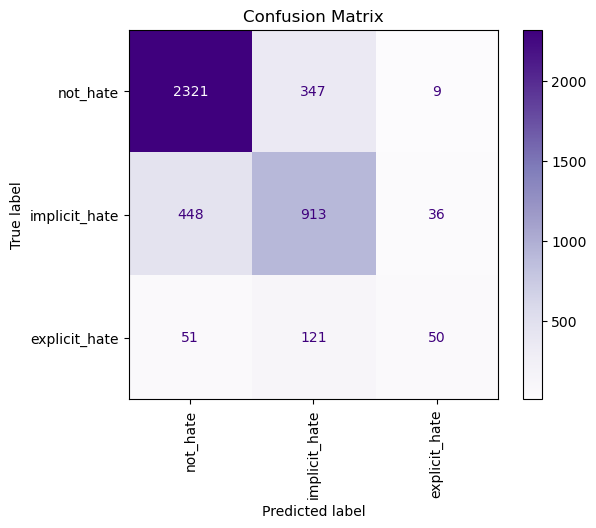

In [22]:
evaluate_predictions(predicted_labels, gold_labels, label_list)


In [23]:
print(tokenized_datasets_dev[0].keys())

posts = [example['post'] for example in tokenized_datasets_dev]  # adjust field name as needed

df = pd.DataFrame({
    "post": posts,
    "predicted_label": predicted_labels,
    "gold_label": gold_labels,
})
df.to_csv("Roberta_predictions_vs_gold_train_dev.csv", index=False)

dict_keys(['post', 'class', 'input_ids', 'attention_mask', 'labels'])


In [24]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions.tolist(), references=labels.tolist())["accuracy"],
        "f1": f1_metric.compute(predictions=predictions.tolist(), references=labels.tolist(), average="weighted")["f1"],
    }


In [25]:
SEED = 237
set_seed(SEED)


model_name = model_checkpoint.split("/")[-1]

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3
)

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-{task}",
    eval_strategy="epoch",  # Updated to use current parameter name
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

trainer1 = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/vd/xkcxq0p96sxd5bgjgdng13s00000gn/T/ipykernel_1823/1562669289.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1 = Trainer(


In [26]:
trainer1.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.707500,0.599220,0.741155,0.721023
2,0.539800,0.556406,0.761406,0.754780


TrainOutput(global_step=1612, training_loss=0.5984205714526306, metrics={'train_runtime': 29508.3259, 'train_samples_per_second': 0.874, 'train_steps_per_second': 0.055, 'total_flos': 2229368210703648.0, 'train_loss': 0.5984205714526306, 'epoch': 2.0})

In [27]:
trainer1.evaluate()

{'eval_loss': 0.5564058423042297,
 'eval_accuracy': 0.7614059590316573,
 'eval_f1': 0.7547801988221394,
 'eval_runtime': 836.2215,
 'eval_samples_per_second': 5.137,
 'eval_steps_per_second': 0.322,
 'epoch': 2.0}

In [28]:
predictions, labels, _ = trainer1.predict(tokenized_datasets_test)
predicted_indices = np.argmax(predictions, axis=1)


In [29]:
label_list = ["not_hate", "implicit_hate", "explicit_hate"]

predicted_labels = [label_list[i] for i in predicted_indices]
gold_labels = [label_list[i] for i in labels]

Accuracy: 0.7614059590316573
Classification Report:
                precision    recall  f1-score   support

     not_hate     0.8180    0.8605    0.8387      2695
implicit_hate     0.6625    0.6422    0.6522      1406
explicit_hate     0.5000    0.2513    0.3345       195

     accuracy                         0.7614      4296
    macro avg     0.6602    0.5847    0.6085      4296
 weighted avg     0.7527    0.7614    0.7548      4296



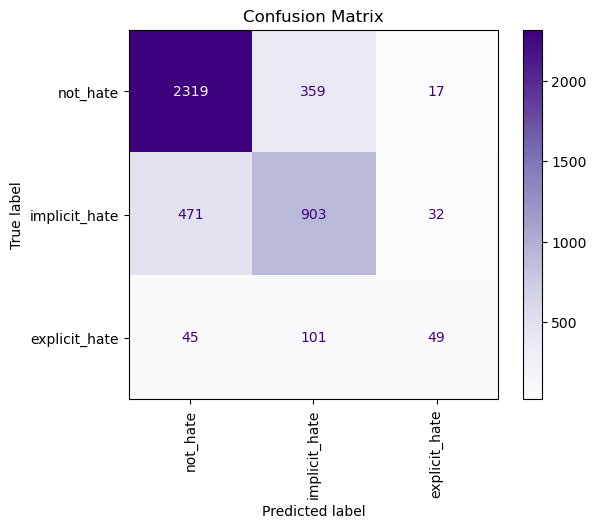

In [30]:
evaluate_predictions(predicted_labels, gold_labels, label_list)
